In [1]:
### RUN EVERY TIME: ESG SOURCE DATASETS EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import math
import itertools
import requests
import json ### To correct JSON structure before unpacking
import gc
import datetime
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats ### To annotate fliers
import seaborn as sns

In [3]:
### RUN EVERY TIME: VERSION CONTROL

from platform import python_version
print('python version: ', python_version())
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)

python version:  3.7.4
numpy version:  1.17.2
pandas version:  0.25.3


In [4]:
### RUN EVERY TIME: MAIN CONSTANTS

### MultiIndex level slice constant:
All = slice(None)
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Dates:
str_date_end = '2023-06-30'
date_start = pd.Timestamp('1989-12-29')
date_end = pd.Timestamp(str_date_end)
date_ison = pd.Timestamp('1994-12-31')
### NA for MS Excel files:
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable']
### World Bank Waste per capita data path and sheets:
str_path_wb_waste_source = 'Data_Files/Source_Files/Waste_per_capita.xlsx'
str_waste_sheet = 'Waste per capita'
### World Bank "What A Waste" Global Database Country level Dataset:
str_path_what_waste_source = 'Data_Files/Source_Files/country_level_data_0.csv'
### World Resource Institute Water stress data path and sheets:
str_path_wri_water_source = 'Data_Files/Source_Files/water_stress.xlsx'
str_water_sheet = '2020 BAU'
### Yale University Environment performance index data paths and sheets:
str_path_bdh_source = 'Data_Files/Source_Files/bdh_history.xlsx'
str_path_epi_source = 'Data_Files/Source_Files/epi_history.xlsx'
### OECD Climate resulting dataset:
str_path_oecd_dataset = 'Data_Files/Source_Files/oecd_climate_dataset.h5'
str_key_oecd_dataset = 'oecd_climate_dataset'
### World Bank API resulting dataset:
str_path_wb_api_dataset = 'Data_Files/Source_Files/wb_api_dataset.h5'
str_key_wb_api_dataset = 'wb_api_dataset'
### World Bank Waste per capita per day resulting dataset:
str_path_wb_waste_dataset = 'Data_Files/Source_Files/wb_waste_dataset.h5'
str_key_wb_waste_dataset = 'wb_waste_dataset'
### World Bank What a Waste dataset:
str_path_what_waste_dataset = 'Data_Files/Source_Files/what_waste_dataset.h5'
str_key_what_waste_dataset = 'what_waste_dataset'
### World Resource Institute Water stress resulting dataset:
str_path_wri_water_dataset = 'Data_Files/Source_Files/wri_water_dataset.h5'
str_key_wri_water_dataset = 'wri_water_dataset'
### Yale University Environment performance index resulting dataset:
str_path_bdh_dataset = 'Data_Files/Source_Files/bdh_dataset.h5'
str_key_bdh_dataset = 'bdh_dataset'
str_path_epi_dataset = 'Data_Files/Source_Files/epi_dataset.h5'
str_key_epi_dataset = 'epi_dataset'
### World Health Organization resulting dataset:
str_path_who_dataset = 'Data_Files/Source_Files/who_dataset.h5'
str_key_who_dataset = 'who_dataset'
### Export files:
str_climate_xlsx = 'Data_Files/Test_Files/climate_change.xlsx'
str_biodiversity_xlsx = 'Data_Files/Test_Files/biodiversity_and_land.xlsx'
str_health_xlsx = 'Data_Files/Test_Files/health.xlsx'
str_boa_esg_xlsx = 'Data_Files/Test_Files/boa_esg.xlsx'

In [5]:
### DEFINING WEIGHTED AVERAGE FOR DATAFRAME COLUMNS

def columns_average(df_series, list_weights = False): 
    ### Single column check
    if (len(df_series.columns) > 1):
        ### Equal weights list creating:
        if isinstance(list_weights, bool):
            list_weights = [1] * len(df_series.columns)
        ### Dataframe of weights initialising:
        df_weights = pd.DataFrame(np.NaN, index = df_series.index, columns = df_series.columns)
        for iter_num, iter_col in enumerate(df_weights.columns):
            df_weights[iter_col] = list_weights[iter_num]
        ### Zeroing weights for NaN values:
        for iter_col in df_weights.columns:
            df_weights.loc[df_series[iter_col].isna(), iter_col] = 0
        ser_mean = (df_series.multiply(df_weights).sum(axis = 1)).div(df_weights.sum(axis = 1))    
        ### Results output:
        del df_series
        del df_weights    
        gc.collect()
    else:
        ser_mean = df_series.squeeze()
        del df_series
        gc.collect()        
    return ser_mean

In [6]:
### DEFINING COUNTRY CODES EXTRACTOR

def get_country_codes(use_local_copy = False):  
    ### In case if URL is unavailable:
    if (use_local_copy):
        url_country_code = 'Data_Files/Source_Files/countrycode.html'
    ### Online extraction:
    else:
        url_country_code = 'https://countrycode.org/'
    df_full_codes = pd.read_html(url_country_code, index_col = 'COUNTRY')[0]
    df_full_codes[['ISO SHORT', 'ISO LONG']] = df_full_codes['ISO CODES'].str.split(' / ', expand = True)
    df_result = df_full_codes[['ISO SHORT', 'ISO LONG']].sort_index()    
    df_result.index = df_result.index.str.upper()
    ### Results output:
    return df_result

In [7]:
### DEFINING EXTRACTION UNIVERSE DATA FROM MS EXCEL SOURCE

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(engine = 'openpyxl', io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                 na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [8]:
### RUN EVERY TIME: COMMON DATA EXTRACTION STEPS

### World Country Codes:
df_country_codes = get_country_codes()
### ISON membership history:
ser_ison_membership = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_end))
### ISON LONG IDs list:
list_ison_long = list(df_country_codes.loc[df_country_codes['ISO SHORT'].isin(ser_ison_membership.index.get_level_values('Country').unique()), 'ISO LONG'].values)
### ISON current status:
ser_ison_status = ser_ison_membership.loc[str_date_end].droplevel('Date')
### ISON stats:
int_ison_number = len(sorted(ser_ison_membership.index.get_level_values(1).unique()))
dict_ison_len = {}
list_regions = ['DM', 'EM', 'FM']
dict_ison_len['ISON'] = len(ser_ison_status)
for iter_region in list_regions:
    dict_ison_len[iter_region] = len(ser_ison_status[ser_ison_status == iter_region])
ser_market_len = pd.Series(dict_ison_len)
ser_market_len.index.names = ['Market']    

In [9]:
### OECD GREEN GROWTH: ALL VARIABLES

In [10]:
### OECD GREEN GROWTH: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
str_oecd_base_url = 'https://stats.oecd.org/sdmx-json/data/'
str_oecd_structure_url = 'https://stats.oecd.org/restsdmx/sdmx.ashx/GetDataStructure/'
str_gg_dataset_add = 'GREEN_GROWTH'

In [11]:
### OECD GREEN GROWTH: REQUESTS SESSION INITIALIZING

request_session = requests.Session()
### For avoiding data request errors:
request_session.headers\
               .update({'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'})

In [12]:
### OECD GREEN GROWTH: STRUCTURE REQUEST

obj_oecd_structure = request_session.get(str_oecd_structure_url + str_gg_dataset_add)
xml_tree_root = et.fromstring(obj_oecd_structure.content)
dict_concepts = {}
dict_dimensions = {}
dict_codelists = {}
for xml_tree_child in xml_tree_root:
    if xml_tree_child.tag.endswith('Concepts'):
        for xml_tree_grand in xml_tree_child:
            str_concept_id = xml_tree_grand.attrib['id']
            str_concept_name = xml_tree_grand[0].text
            dict_concepts[str_concept_id] = str_concept_name
    if xml_tree_child.tag.endswith('KeyFamilies'):
        for xml_tree_family in xml_tree_child:
            for xml_tree_component in xml_tree_family:
                if xml_tree_component.tag.endswith('Components'):
                    for xml_tree_measure in xml_tree_component:
                        if xml_tree_measure.tag.endswith('Dimension'):
                            str_concept_id = xml_tree_measure.attrib['conceptRef']
                            str_concept_cl_id = xml_tree_measure.attrib['codelist']
                            dict_dimensions[str_concept_id] = str_concept_cl_id
    if xml_tree_child.tag.endswith('CodeLists'):       
        for num_tree_grand, xml_tree_grand in enumerate(xml_tree_child):
            str_codelist_id = xml_tree_grand.attrib['id']
            dict_codelist = {}
            for xml_tree_codelist in xml_tree_grand:                
                if xml_tree_codelist.tag.endswith('Code'):
                    str_code_id = xml_tree_codelist.attrib['value']
                    str_code_value = xml_tree_codelist[0].text
                    dict_codelist[str_code_id] = str_code_value
            dict_codelists[str_codelist_id] = dict_codelist

In [13]:
### OECD GREEN GROWTH: DIMENSIONS

pd.concat([pd.Series(dict_concepts), pd.Series(dict_dimensions)], axis = 1, sort = False).dropna()

,0,1
COU,Country,CL_GREEN_GROWTH_COU
VAR,Variable,CL_GREEN_GROWTH_VAR
YEA,Year,CL_GREEN_GROWTH_YEA


In [ ]:
### TEMP

dict_codelists['CL_GREEN_GROWTH_VAR']

In [24]:
### OECD GREEN GROWTH CONCEPT SOURCE CODELISTS:

dict_codelists['CL_GREEN_GROWTH_VAR'] 
# 'CO2_PBPROD' - 'Production-based CO2 productivity, GDP per unit of energy-related CO2 emissions' (need to be reciprocated)
# 'CO2_PBEMCAP': 'Production-based CO2 intensity, energy-related CO2 per capita',
# 'RE_TPES' - 'Renewable energy supply, % total energy supply'
# 'NRG_PROD' - 'Energy productivity,  GDP per unit of TPES'
# 'MWAS_INT': 'Municipal waste generated, kg per capita'
# 'WATER_FWCAP': 'Total freshwater abstraction per capita'
# 'PM_PWM': 'Mean population exposure to PM2.5'
#dict_variables = {}
#dict_variables['CO2_PBPROD'] = 'CO2 Emission per GDP (OECD)' #  (need to be reciprocated)
#dict_variables['CO2_PBEMCAP'] = 'CO2 Emission per capita (OECD)'
#dict_variables['RE_TPES'] = 'Renewable Energy (OECD)'
#dict_variables['MWAS_INT'] = 'Municipal Waste per capita (OECD)'
#dict_variables['WATER_FWCAP'] = 'Freshwater Abstraction per capita (OECD)'
#dict_variables['PM_PWM'] = 'Mean population exposure to PM2.5 (OECD)'
#dict_variables = dict_codelists['CL_GREEN_GROWTH_VAR']
dict_variables = {iter_code : dict_codelists['CL_GREEN_GROWTH_VAR'][iter_code].replace(',' , ':') + ' (OECD)' for iter_code in dict_codelists['CL_GREEN_GROWTH_VAR']}

In [25]:
### OECD GREEN GROWTH: PARAMETERS PREPARATION: Reporters and partners control and preparation

### ISON Countries collecting:
df_ison_countries = df_country_codes.set_index('ISO SHORT', append = True).reset_index('COUNTRY', drop = True)
df_ison_countries = df_ison_countries.reindex(ser_ison_membership.index.get_level_values(1).unique().to_list())
ser_ison_countries = df_ison_countries.reset_index().set_index('ISO LONG').squeeze()
### OECD reporters vs ISON members:
ser_oecd_reporters = pd.Series(dict_codelists['CL_GREEN_GROWTH_COU'])
ser_oecd_reporters = ser_oecd_reporters.to_frame().join(ser_ison_countries).drop(0, axis = 1).squeeze()
for iter_iso_long in (ser_oecd_reporters[ser_oecd_reporters.isna()].index.get_level_values(0)):
    if iter_iso_long in ser_ison_countries.index:
        print('OECD Reporter country with no ISON match:', iter_iso_long)
### ISON countries with no OECD reporter match:
set_no_reporters = set(ser_ison_countries.dropna().index) - set(ser_oecd_reporters.index)
print('ISON countries with no OECD reporter match:', set_no_reporters, '(', len(set_no_reporters), ')')

ISON countries with no OECD reporter match: {'TWN', 'HKG'} ( 2 )


In [26]:
### OECD GREEN GROWTH: PARAMETERS PREPARATION: NON-TIME PARAMETERS:

### Green growth climate variables:
str_variables = '+'.join(dict_variables.keys())
### Countries parameter preparation:
str_reporters_all = '+'.join(sorted(list(set(ser_ison_countries.dropna().index) & set(ser_oecd_reporters.index))))

In [27]:
### OECD GREEN GROWTH: CLIMATE CHANGE REQUEST CONSTRUCTING

str_gg_climate_request_params = '.'.join([str_reporters_all, str_variables])
str_gg_climate_request = str_oecd_base_url + str_gg_dataset_add + '/' + str_gg_climate_request_params + '/all?startTime=1980&endTime=2023&detail=DataOnly'
obj_gg_climate_dataset = request_session.get(str_gg_climate_request).json()

In [28]:
### OECD GREEN GROWTH: CLIMATE CHANGE INDEX DATA COLLECTING:

### Dates:
list_idx_dates = []
for tup_date in obj_gg_climate_dataset['structure']['dimensions']['observation'][0]['values']:
    list_idx_dates.append(pd.to_datetime(tup_date['id']) + pd.offsets.BYearEnd())
### Parameters:    
list_idx_library = []
for iter_position in obj_gg_climate_dataset['structure']['dimensions']['series']:
    list_param_values = []
    for tup_parameter in iter_position['values']:
        list_param_values.append(tup_parameter['id'])            
    list_idx_library.append(list_param_values)
### Result:
list_idx_library.append(list_idx_dates)
### Converting to dictionary for future replacing:
list_idx_dict = []
for iter_list in list_idx_library:
    list_idx_dict.append(dict(zip(map(str, range(len(iter_list))), iter_list)))

In [29]:
### OECD GREEN GROWTH: CLIMATE CHANGE DATASET RESAMPLING

dict_datasets_res = {}
dict_datasets_source = obj_gg_climate_dataset['dataSets'][0]['series']
### Parameters and date indexes integration:
for iter_dataset in dict_datasets_source:
    dict_observations = dict_datasets_source[iter_dataset]['observations']
    for iter_observation in dict_observations:
        str_iter_idx = iter_dataset + ':' + iter_observation
        flo_iter_value = dict_observations[iter_observation][0]
        dict_datasets_res[str_iter_idx] = flo_iter_value

In [30]:
### OECD GREEN GROWTH: CLIMATE CHANGE DATASET REINDEXATION

df_gg_climate_data = pd.Series(dict_datasets_res)
df_gg_climate_data.index = pd.MultiIndex.from_arrays(zip(*df_gg_climate_data.index.str.split(':')))
int_levels_number = df_gg_climate_data.index.nlevels
df_gg_climate_data = df_gg_climate_data.reset_index()
### Replacing numbers with parameter values:
for iter_level in range(int_levels_number):
    df_gg_climate_data['level_' + str(iter_level)].replace(list_idx_dict[iter_level], inplace = True)
    ### Replacing long ISO names with short ISO names:
    if (iter_level == 0):
        df_gg_climate_data['level_' + str(iter_level)].replace(dict(zip(ser_oecd_reporters.index, ser_oecd_reporters)), inplace = True)
    ### Variables renaming:
    elif (iter_level == 1):
        df_gg_climate_data['level_' + str(iter_level)].replace(dict_variables, inplace = True)
### Indexes defining:
ser_gg_climate_data = df_gg_climate_data.set_index(['level_1', 'level_2', 'level_0']).squeeze()
ser_gg_climate_data.index.names = ['Variable', 'Date', 'Country']
ser_gg_climate_data.sort_index(inplace = True)
ser_gg_climate_data.name = 'OECD Climate'
### CO2 Emission reciprocating:
df_gg_climate_var = ser_gg_climate_data.unstack('Variable')
#df_gg_climate_var['CO2 Emission per GDP'] = 1.0 / df_gg_climate_var['CO2 Emission per GDP']
ser_gg_climate_var = df_gg_climate_var.stack('Variable', dropna = False).reorder_levels([2, 0, 1]).sort_index()

In [33]:
### OECD GREEN GROWTH: CLIMATE CHANGE SAVING

ser_gg_climate_var.to_hdf(path_or_buf = str_path_oecd_dataset, key = str_key_oecd_dataset, mode = 'w')

In [98]:
### OECD GREEN GROWTH: CLIMATE CHANGE: TEST

ser_gg_climate_var = pd.read_hdf(path_or_buf = str_path_oecd_dataset, key = str_key_oecd_dataset)
ser_gg_climate_var.loc[All, ['1990-12-31', '1995-12-29', '2020-12-31'], ['IL']].sort_index().unstack('Variable')
ser_gg_climate_var.unstack('Variable').loc[(['2018-12-31', '2019-12-31', '2020-12-31', '2021-12-31', '2022-12-31'], ['AU', 'CN', 'US']), :]

Variable            CO2 Emission per GDP (OECD)  \
Date       Country                                
2018-12-31 AU                              3.09   
           CN                              2.22   
           US                              3.97   
2019-12-31 AU                              3.10   
           CN                              2.32   
           US                              4.20   
2020-12-31 AU                              3.30   
           CN                              2.33   
           US                              4.55   
2021-12-31 AU                              3.38   
           US                              4.58   

Variable            CO2 Emission per capita (OECD)  \
Date       Country                                   
2018-12-31 AU                                15.67   
           CN                                 6.85   
           US                                15.02   
2019-12-31 AU                                15.35   
           CN                                 6.93   
           US                                14.45   
2020-12-31 AU                                14.57   
           CN                                 7.00   
           US                                12.84   
2021-12-31 AU                                14.71   
           US                                13.51   

Variable            Freshwater Abstraction per capita (OECD)  \
Date       Country                                             
2018-12-31 AU                                         702.63   
           CN                                         415.31   
           US                                            NaN   
2019-12-31 AU                                         607.63   
           CN                                         412.66   
           US                                            NaN   
2020-12-31 AU                                         522.70   
           CN                                            NaN   
           US                                            NaN   
2021-12-31 AU                                            NaN   
           US                                            NaN   

Variable            Mean population exposure to PM2.5 (OECD)  \
Date       Country                                             
2018-12-31 AU                                           6.74   
           CN                                          49.33   
           US                                           7.79   
2019-12-31 AU                                           6.75   
           CN                                          47.73   
           US                                           7.68   
2020-12-31 AU                                            NaN   
           CN                                            NaN   
           US                                            NaN   
2021-12-31 AU                                            NaN   
           US                                            NaN   

Variable            Municipal Waste per capita (OECD)  Renewable Energy (OECD)  
Date       Country                                                              
2018-12-31 AU                                  507.73                     7.04  
           CN                                     NaN                     9.36  
           US                                  810.85                     7.78  
2019-12-31 AU                                  498.82                     7.28  
           CN                                     NaN                     9.68  
           US                                     NaN                     7.90  
2020-12-31 AU                                     NaN                     7.56  
           CN                                     NaN                    10.01  
           US                                     NaN                     8.43  
2021-12-31 AU                                     NaN                     8.

In [99]:
### WORLD BANK: WDI: ALL VARIABLES

In [100]:
### WORLD BANK: WDI: ALL VARIABLES: GENERAL DATA PREPARATION

All = slice(None)
str_wdi_base_url = 'http://api.worldbank.org/v2/'
str_wdi_request_format = '?format=json&per_page=29999'

In [102]:
### WORLD BANK: WDI: INDICATORS LIST

### Session initializing:
request_session = requests.Session()
### Data loading:
obj_wb_indicators = request_session.get(str_wdi_base_url + 'indicator' + str_wdi_request_format)
list_indicators = obj_wb_indicators.json()[1]
df_indicators = pd.DataFrame(list_indicators)
print('Indicators registry length:', len(df_indicators))
### Indicators search and saving:
display(df_indicators.loc[df_indicators['name'].str.contains('PM2.5 air pollution'), ['id', 'name']])
display(df_indicators.loc[df_indicators['name'].str.contains('resources depletion'), ['id', 'name']])
dict_variables = {}
dict_variables['EN.ATM.PM25.MC.M3'] = 'PM 2.5 air pollution per cubic meter (WB)'
dict_variables['EN.ATM.PM25.MC.ZS'] = 'PM 2.5 air pollution, % of population exposed (WB)'
dict_variables['NY.ADJ.DRES.GN.ZS'] = 'Natural resources depletion (WB)'

Indicators registry length: 20939


,id,name
6177,EN.ATM.PM25.MC.M3,"PM2.5 air pollution, mean annual exposure (mic..."
6181,EN.ATM.PM25.MC.ZS,"PM2.5 air pollution, population exposed to lev..."


,id,name
11918,NY.ADJ.DRES.GN.ZS,Adjusted savings: natural resources depletion ...


In [103]:
### WORLD BANK: WDI: ALL VARIABLES: DATA EXTRACTING

gc.collect()
### Session initializing:
request_session = requests.Session()
### Results container:
dict_results = {}
### List of ISON countries converting:
str_reporters_all = ';'.join(sorted(list_ison_long))
### Looping over variables:
for iter_var in dict_variables:
    ### URL for API request:
    str_iter_url = str_wdi_base_url + 'country/' + str_reporters_all + '/indicator/' + iter_var + \
                   str_wdi_request_format + '&date=' + str(date_start.year) + ':' + str(date_end.year)
    ### API response:
    obj_iter_dataset = request_session.get(str_iter_url)
    ### Data converting from JSON to pandas:
    ser_iter_country_id = pd.DataFrame(obj_iter_dataset.json()[1])['country'].apply(pd.Series)['id']
    df_iter_dataset = pd.concat([ser_iter_country_id, pd.DataFrame(obj_iter_dataset.json()[1])[['date', 'value']]], axis = 1)
    df_iter_dataset.columns = ['Country', 'Year', 'Value']
    df_iter_dataset['Date'] = pd.to_datetime(df_iter_dataset['Year']) + pd.offsets.BYearEnd()
    ### Adding data to container:
    dict_results[dict_variables[iter_var]] = df_iter_dataset.set_index(['Date', 'Country'])['Value'].sort_index()
#    break
### Data aggregating and saving:
pd.concat(dict_results, axis = 1).stack().reorder_levels([2, 0, 1])
ser_wb_api_data = pd.concat(dict_results, axis = 1).stack().reorder_levels([2, 0, 1])
ser_wb_api_data.index.rename('Variable', level = 0, inplace = True)
ser_wb_api_data.to_hdf(path_or_buf = str_path_wb_api_dataset, key = str_key_wb_api_dataset, mode = 'w')

In [ ]:
### WORLD BANK: WDI: API TEST

ser_wb_api_data = pd.read_hdf(path_or_buf = str_path_wb_api_dataset, key = str_key_wb_api_dataset)
ser_wb_api_data.loc[All, ['1990-12-31', '1995-12-29', '2020-12-31'], ['IL']].sort_index().unstack('Variable')
ser_wb_api_data.unstack('Variable').loc[(All, 'AU'),:]

In [54]:
### WORLD BANK: WASTE PER CAPITA

In [55]:
### WORLD BANK: WASTE PER CAPITA: LOADING & SAVING

ser_wb_waste_raw = pd.read_excel(engine = 'openpyxl', io = str_path_wb_waste_source, sheet_name = str_waste_sheet, index_col = [0], header = [0],
                                na_values = list_na_excel_values, keep_default_na = False).squeeze()
ser_wb_waste_raw.index = ser_wb_waste_raw.index.str.upper()
ser_wb_waste_res = ser_wb_waste_raw.to_frame().reset_index().merge(df_country_codes, left_on = 'Country', right_on = 'COUNTRY')\
                                   .set_index('ISO SHORT')['Waste generation rate']
ser_wb_waste_res.index.names = ['Country']
ser_wb_waste_res = pd.concat({'Waste per Capita': pd.concat({pd.Timestamp('2016-12-30'): ser_wb_waste_res}, names = ['Date'])}, names = ['Variable'])
ser_wb_waste_res.to_hdf(path_or_buf = str_path_wb_waste_dataset, key = str_key_wb_waste_dataset, mode = 'w')

In [56]:
### WORLD BANK: WDI: TEST

ser_wb_waste_res = pd.read_hdf(path_or_buf = str_path_wb_waste_dataset, key = str_key_wb_waste_dataset)
ser_wb_waste_res.unstack('Variable')

Variable            Waste per Capita
Date       Country                  
2016-12-30 AR                   1.14
           AU                   1.54
           AT                   1.54
           BH                   1.83
           BD                   0.28
...                              ...
           GB                   1.33
           UY                   1.01
           US                   2.24
           VN                   0.33
           ZM                   0.51

[86 rows x 1 columns]

In [10]:
### WORLD BANK: WHAT A WASTE

In [56]:
### WORLD BANK: WHAT A WASTE: LOADING & SAVING

df_what_waste_raw = pd.read_csv(str_path_what_waste_source, header = [0], sep = ',', na_values = 'NA', keep_default_na = False)
df_what_waste_raw.drop(['region_id', 'country_name', 'income_id', 'gdp', 'where_where_is_this_data_measured', 'waste_treatment_waterways_marine_percent',
                        'population_population_number_of_people', 'other_information_information_system_for_solid_waste_management', 
                        'other_information_national_agency_to_enforce_solid_waste_laws_and_regulations',
                        'other_information_national_law_governing_solid_waste_management_in_the_country',
                        'other_information_ppp_rules_and_regulations', 'other_information_summary_of_key_solid_waste_information_made_available_to_the_public'], 
                       axis = 1, inplace = True)

df_what_waste_ison = df_what_waste_raw.merge(df_country_codes, left_on = 'iso3c', right_on = 'ISO LONG').drop(['iso3c', 'ISO LONG'], axis = 1).set_index('ISO SHORT')
df_what_waste_ison.index.names = ['Country']
df_what_waste_ison = df_what_waste_ison.reindex(ser_ison_membership.index.get_level_values('Country').unique()).sort_index()
ser_what_waste_ison = df_what_waste_ison.stack().swaplevel().sort_index()
ser_what_waste_ison.index.names = ['Variable', 'Country']
ser_what_waste_ison = pd.concat({pd.Timestamp('2018-12-31'): ser_what_waste_ison}, names = ['Date'])
ser_what_waste_ison.to_hdf(path_or_buf = str_path_what_waste_dataset, key = str_key_what_waste_dataset, mode = 'w')

In [13]:
### WORLD BANK: WHAT A WASTE: TEST

ser_what_waste_ison = pd.read_hdf(path_or_buf = str_path_what_waste_dataset, key = str_key_what_waste_dataset)
#ser_what_waste_ison.unstack('Variable')
ser_what_waste_ison.index.levels[1]

Index(['composition_food_organic_waste_percent', 'composition_glass_percent',
       'composition_metal_percent', 'composition_other_percent',
       'composition_paper_cardboard_percent', 'composition_plastic_percent',
       'composition_rubber_leather_percent', 'composition_wood_percent',
       'composition_yard_garden_green_waste_percent',
       'special_waste_agricultural_waste_tons_year',
       'special_waste_construction_and_demolition_waste_tons_year',
       'special_waste_e_waste_tons_year',
       'special_waste_hazardous_waste_tons_year',
       'special_waste_industrial_waste_tons_year',
       'special_waste_medical_waste_tons_year',
       'total_msw_total_msw_generated_tons_year',
       'waste_collection_coverage_rural_percent_of_geographic_area',
       'waste_collection_coverage_rural_percent_of_households',
       'waste_collection_coverage_rural_percent_of_population',
       'waste_collection_coverage_rural_percent_of_waste',
       'waste_collection_coverage_t

In [57]:
### WORLD RESOURCE INSTITUTE: WATER STRESS

In [58]:
### WORLD RESOURCE INSTITUTE: WATER STRESS: LOADING & SAVING

ser_wri_water_raw = pd.read_excel(engine = 'openpyxl', io = str_path_wri_water_source, sheet_name = str_water_sheet, usecols = list(range(1, 6)), index_col = [0],
                                 header = [0], na_values = list_na_excel_values + ['No data'], keep_default_na = False).squeeze()
ser_wri_water_raw.index = ser_wri_water_raw.index.str.upper()
ser_wri_water_res = ser_wri_water_raw.reset_index().merge(df_country_codes, left_on = 'Name', right_on = 'COUNTRY')\
                                   .set_index('ISO SHORT')['All Sectors']
ser_wri_water_res = ser_wri_water_res.reindex(ser_ison_membership.index.get_level_values('Country').unique())
ser_wri_water_res.index.names = ['Country']
ser_wri_water_res = pd.concat({'Water Stress': pd.concat({pd.Timestamp('2020-12-31'): ser_wri_water_res}, names = ['Date'])}, names = ['Variable'])
ser_wri_water_res.to_hdf(path_or_buf = str_path_wri_water_dataset, key = str_key_wri_water_dataset, mode = 'w')

In [59]:
### WORLD RESOURCE INSTITUTE: WATER STRESS: TEST

ser_wri_water_res = pd.read_hdf(path_or_buf = str_path_wri_water_dataset, key = str_key_wri_water_dataset)
ser_wri_water_res.unstack('Variable')

Variable            Water Stress
Date       Country              
2020-12-31 AT           0.441201
           AU           3.296550
           BE           3.502610
           CA           1.035820
           CH           1.141830
...                          ...
           RS                NaN
           CR           1.014780
           UG           0.001702
           ZM           0.000000
           IS           0.000000

[85 rows x 1 columns]

In [9]:
### YALE UNIVERSITY: BIODIVERSITY & HABITAT

In [15]:
### YALE UNIVERSITY: BIODIVERSITY & HABITAT: DATA LOADING

dict_bio_raw = pd.read_excel(engine = 'openpyxl', io = str_path_bdh_source, sheet_name = None, header = None, na_values = ['NA', '..'], keep_default_na = False)
dict_epi_container = {}
for iter_year in dict_bio_raw:
    df_bio_iter_raw = dict_bio_raw[iter_year]
    ser_bio_iter_res = df_bio_iter_raw.merge(df_country_codes, left_on = 0, right_on = 'ISO LONG').drop([0, 'ISO LONG'], axis = 1).set_index('ISO SHORT').squeeze()
    dict_epi_container[(pd.to_datetime(iter_year)  + pd.offsets.BYearEnd()).date()] = ser_bio_iter_res[ser_ison_status.index]
ser_bio_res = pd.concat(dict_epi_container, axis = 1, sort = False).stack().swaplevel().sort_index().astype('float32')
ser_bio_res.index.names = ['Date', 'Country']
ser_bio_filled = ser_bio_res.unstack('Country').reindex(pd.date_range(date_start, date_end, freq = 'BY')).ffill().bfill().stack('Country').sort_index()
ser_bio_filled.index.names = ['Date', 'Country']
ser_bio_filled.name = 'Biodiversity'
ser_bio_filled.to_csv('Data_Files/Test_Files/EPI_Biodiversity.csv', sep = ',', header = True)

In [16]:
### YALE UNIVERSITY: ENVIRONMENT PERFORMANCE INDEX: DATA LOADING

dict_epi_raw = pd.read_excel(engine = 'openpyxl', io = str_path_epi_source, sheet_name = None, header = None, na_values = ['NA', '..'], keep_default_na = False)
dict_epi_container = {}
for iter_year in dict_epi_raw:
    df_epi_iter_raw = dict_epi_raw[iter_year]
    ser_epi_iter_res = df_epi_iter_raw.merge(df_country_codes, left_on = 0, right_on = 'ISO LONG').drop([0, 'ISO LONG'], axis = 1).set_index('ISO SHORT').squeeze()
    dict_epi_container[(pd.to_datetime(iter_year)  + pd.offsets.BYearEnd()).date()] = ser_epi_iter_res[ser_ison_status.index]
ser_epi_res = pd.concat(dict_epi_container, axis = 1, sort = False).stack().swaplevel().sort_index().astype('float32')
ser_epi_res.index.names = ['Date', 'Country']
ser_epi_filled = ser_epi_res.unstack('Country').reindex(pd.date_range(date_start, date_end, freq = 'BY')).ffill().bfill().stack('Country').sort_index()
ser_epi_filled.index.names = ['Date', 'Country']
ser_epi_filled.name = 'EPI'
ser_epi_filled.to_csv('Data_Files/Test_Files/EPI_Main_Index.csv', sep = ',', header = True)

In [63]:
### YALE UNIVERSITY: BIODIVERSITY & HABITAT: VARIABLES AGGREGATION & SAVING

df_bio_all = ser_bio_all.unstack('Variable')
df_bio_all = df_bio_all[sorted(df_bio_all.columns)]    
ser_bio_bdh = columns_average(df_bio_all, df_bio_info['Weight'].values)
ser_bio_bdh = pd.concat({'Biodiversity': ser_bio_bdh}, names = ['Variable'])
ser_bio_bdh.to_hdf(path_or_buf = str_path_bdh_dataset, key = str_key_bdh_dataset, mode = 'w')

In [68]:
### YALE UNIVERSITY: BIODIVERSITY & HABITAT: TEST

ser_bio_bdh = pd.read_hdf(path_or_buf = str_path_bdh_dataset, key = str_key_bdh_dataset)
ser_bio_bdh.unstack('Variable')

Variable            Biodiversity
Date       Country              
1995-12-29 AE           8.701630
           AR          21.627001
           AT          70.230373
           AU          25.952407
           BD          30.198488
...                          ...
2022-12-30 UG          75.796751
           US          60.600451
           VN          27.870742
           ZA          54.668969
           ZM          90.970279

[2380 rows x 1 columns]

In [28]:
### WHO: ALL VARIABLES

In [29]:
### WHO: ALL VARIABLES: GENERAL DATA PREPARATION

All = slice(None)
str_who_base_url = 'https://ghoapi.azureedge.net/api/'
str_who_dimensions_add = 'Dimension'
str_who_dimension_values_add = 'DimensionValues'
str_who_indicators_add = 'Indicator'

In [30]:
### WHO: ALL VARIABLES: REQUESTS SESSION INITIALIZING

request_session = requests.Session()

In [31]:
### WHO: ALL VARIABLES: DIMENSIONS LIST LOADING

### Codelists info loading:
obj_who_dimensions_list = request_session.get(str_who_base_url + str_who_dimensions_add)
list_dimensions = obj_who_dimensions_list.json()['value']
### Dimensions collection:
ser_who_dimension = pd.DataFrame(list_dimensions).set_index('Code').squeeze()

In [32]:
### WHO: ALL VARIABLES: INDICATORS LIST FILTERING

### Filter substrings to search attributes:
dict_who_filters = {}
dict_who_filters['Vaccination coverage'] = 'Diphtheria tetanus'
dict_who_filters['Hospital beds density'] = 'Hospital beds (per'
dict_who_filters['Density of doctors'] = 'Medical doctors (per'
### Indicators container:
dict_who_indicators = {}
### Proper indicators filtering:
for iter_attr in dict_who_filters:
    obj_who_iter_attribute = request_session.get(str_who_base_url + str_who_indicators_add + "?$filter=startswith(IndicatorName, \'" + 
                                                 str(dict_who_filters[iter_attr]) + "\')")
    dict_iter_attr = obj_who_iter_attribute.json()['value'][0]
    print(dict_iter_attr)
    dict_who_indicators[iter_attr] = dict_iter_attr['IndicatorCode']

{'IndicatorCode': 'WHS4_100', 'IndicatorName': 'Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)', 'Language': 'EN'}
{'IndicatorCode': 'WHS6_102', 'IndicatorName': 'Hospital beds (per 10 000 population)', 'Language': 'EN'}
{'IndicatorCode': 'HWF_0001', 'IndicatorName': 'Medical doctors (per 10,000)', 'Language': 'EN'}


In [33]:
### WHO: ALL VARIABLES: INDICATORS DATA LOADING

### Datasets container:
dict_who_data = {}
### Looping over WHO indicators:
for iter_attr in dict_who_indicators:
    ### Dataset loading:
    obj_who_iter_dataset = request_session.get(str_who_base_url + dict_who_indicators[iter_attr])
    df_iter_dataset = pd.DataFrame(obj_who_iter_dataset.json()['value'])
    ### Dataset filtering:
    df_iter_dataset = df_iter_dataset.loc[(df_iter_dataset['SpatialDimType'] == 'COUNTRY') & (df_iter_dataset['SpatialDim'].isin(list_ison_long)), 
                                          ['SpatialDim', 'TimeDim', 'Value']]
    df_iter_dataset = df_iter_dataset.merge(df_country_codes, left_on = 'SpatialDim', right_on = 'ISO LONG')[['TimeDim', 'ISO SHORT', 'Value']]
    ### Casting:
    df_iter_dataset['Date'] = pd.to_datetime(df_iter_dataset['TimeDim'], format = '%Y') +  pd.offsets.BYearEnd()
    df_iter_dataset['Country'] = df_iter_dataset['ISO SHORT']
    df_iter_dataset['Value'] = df_iter_dataset['Value'].astype(float)
    ### Turning to Series and saving:
    dict_who_data[iter_attr] = df_iter_dataset.set_index(['Date', 'Country'])['Value']
### Data saving:
pd.concat(dict_who_data, axis = 0, names = ['Variable']).squeeze().to_hdf(path_or_buf = str_path_who_dataset, key = str_key_who_dataset, mode = 'w')

In [67]:
### ESG INDICATORS CONSOLIDATING

df_gg_climate_var = pd.read_hdf(path_or_buf = str_path_oecd_dataset, key = str_key_oecd_dataset).unstack('Variable')
df_wb_api_data = pd.read_hdf(path_or_buf = str_path_wb_api_dataset, key = str_key_wb_api_dataset).unstack('Variable')
df_wb_waste_res = pd.read_hdf(path_or_buf = str_path_wb_waste_dataset, key = str_key_wb_waste_dataset).unstack('Variable')
df_what_waste_ison = pd.read_hdf(path_or_buf = str_path_what_waste_dataset, key = str_key_what_waste_dataset).unstack('Variable')
df_wri_water_res = pd.read_hdf(path_or_buf = str_path_wri_water_dataset, key = str_key_wri_water_dataset).unstack('Variable')
df_bio_bdh = pd.read_hdf(path_or_buf = str_path_bdh_dataset, key = str_key_bdh_dataset).unstack('Variable')
#df_who_health = pd.read_hdf(path_or_buf = str_path_who_dataset, key = str_key_who_dataset).unstack('Variable')
df_all_var = pd.concat([df_gg_climate_var, df_wb_api_data, df_wb_waste_res, df_wri_water_res, df_bio_bdh], axis = 1)
#df_climate = df_all_var[['CO2 Emission', 'PM 2.5 air pollution', 'Renewable Energy', 'Energy Productivity']]
#df_climate.to_excel(str_climate_xlsx, merge_cells = False)
#df_biodiversity = df_all_var[['Waste per Capita', 'Natural resource depletion', 'Water Stress', 'Biodiversity']]
#df_biodiversity.to_excel(str_biodiversity_xlsx, merge_cells = False)
#df_health = df_all_var[['Vaccination coverage', 'Hospital beds density', 'Density of doctors']]
#df_health.to_excel(str_health_xlsx, merge_cells = False)
#df_all_var.to_excel(str_boa_esg_xlsx, merge_cells = False)
df_what_waste_ison.to_csv('Data_Files/Test_Files/what_a_waste.csv', sep = ',')

CO2 Emission per GDP


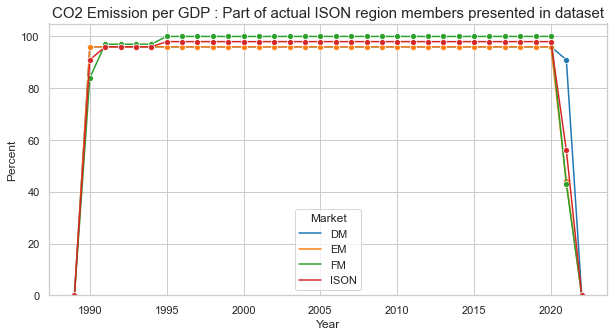

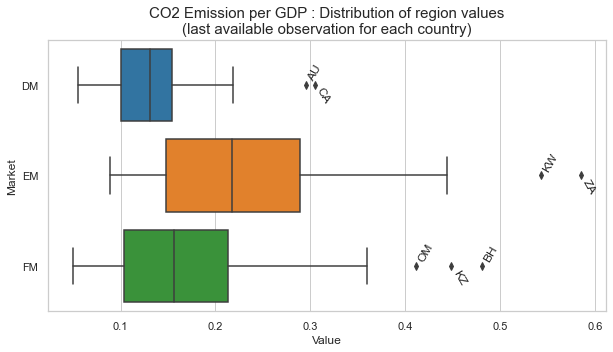

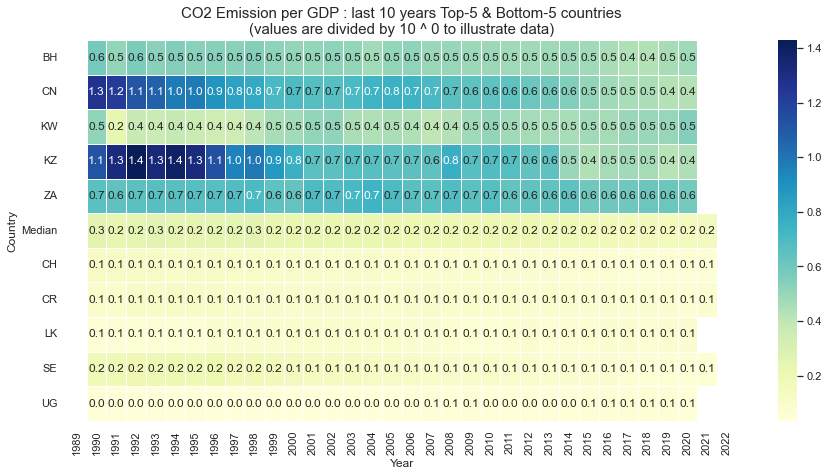

CO2 Emission per capita


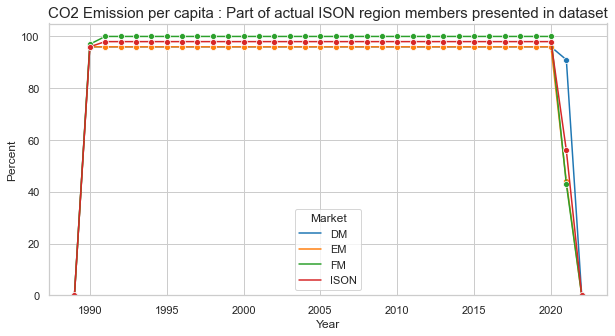

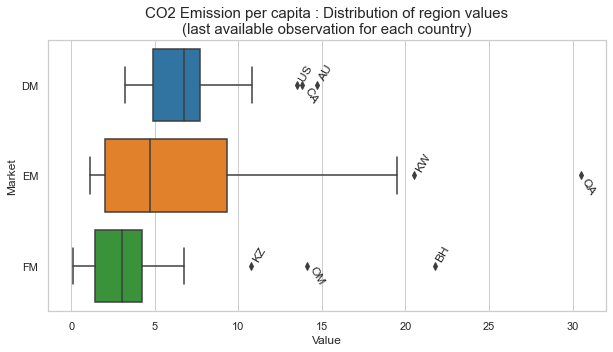

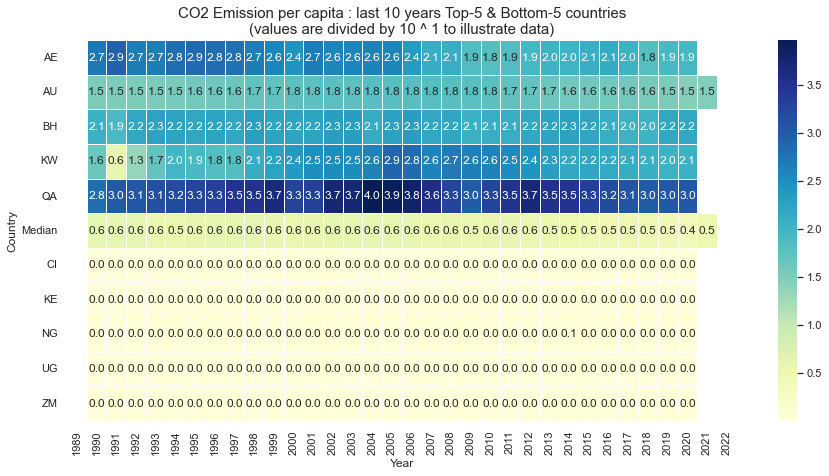

Freshwater Abstraction per capita


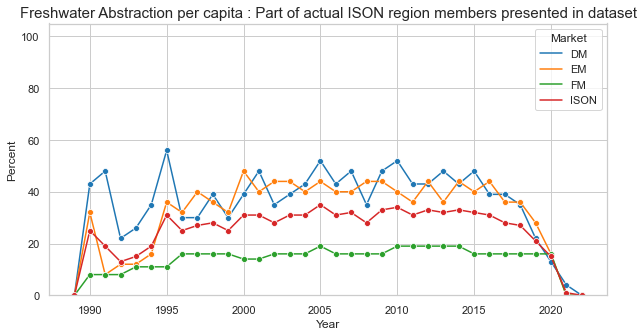

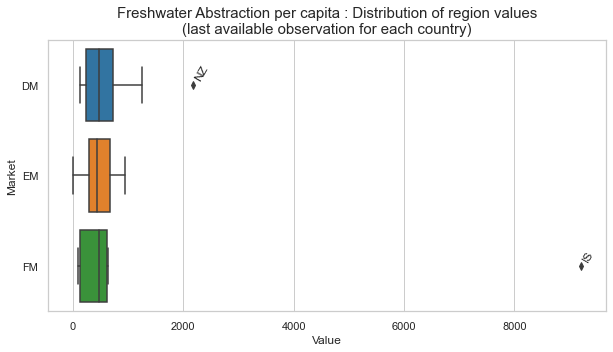

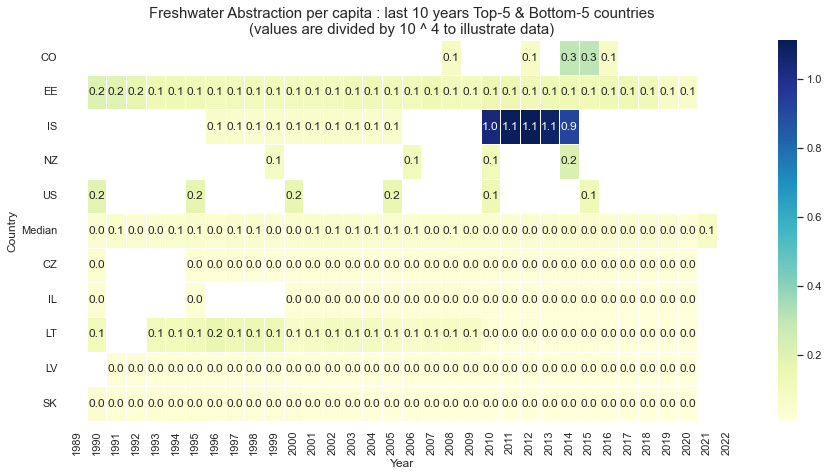

Municipal Waste per capita


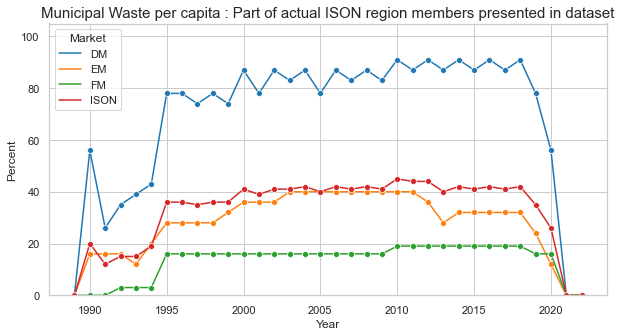

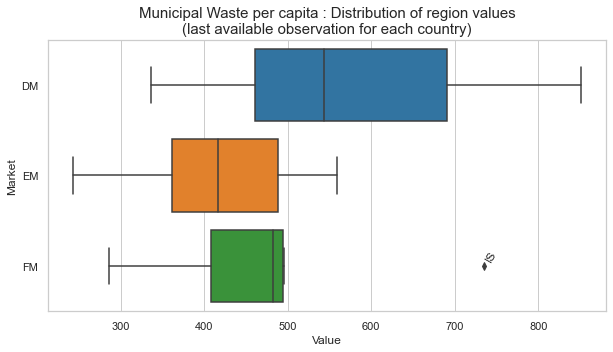

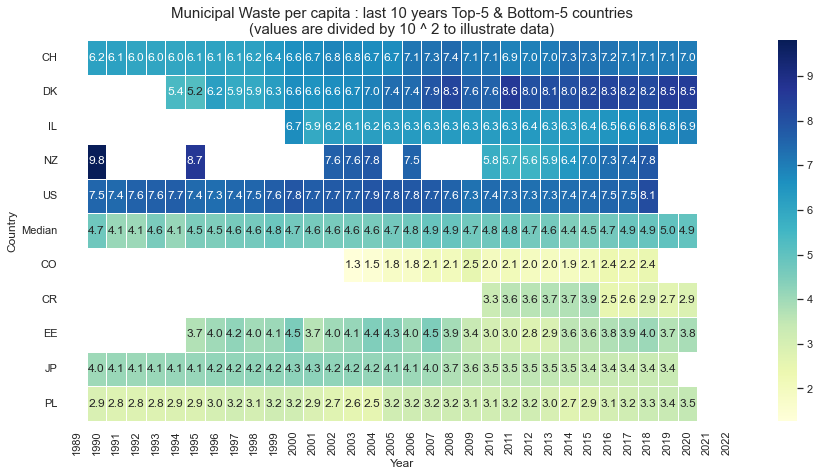

Renewable Energy


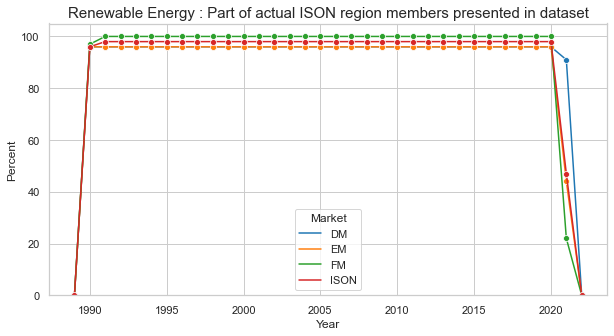

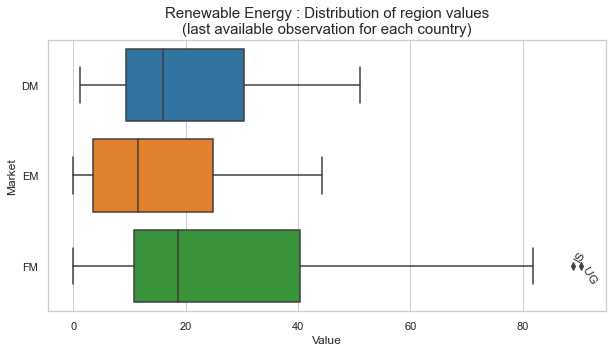

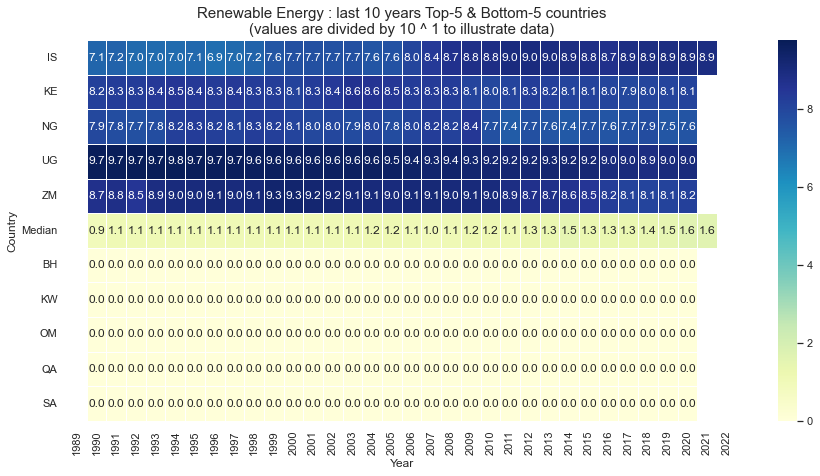

PM 2.5 air pollution per cubic meter


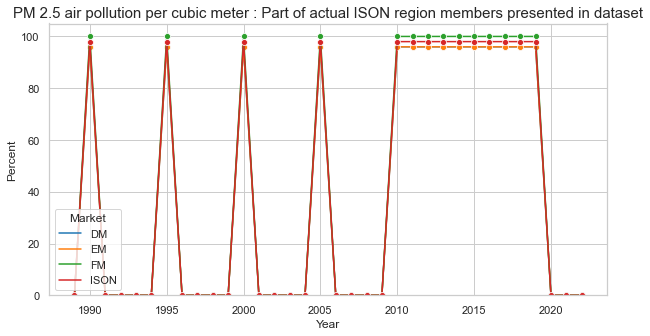

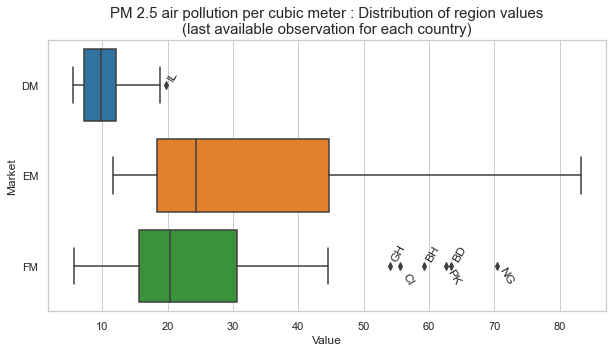

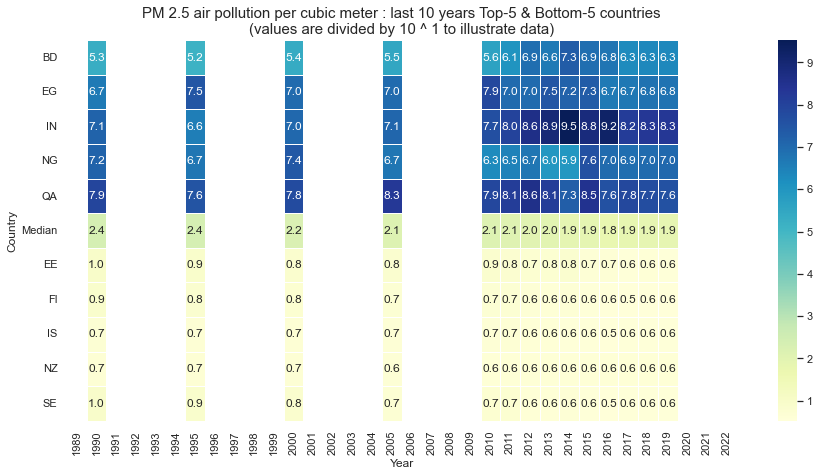

PM 2.5 air pollution, % of population exposed


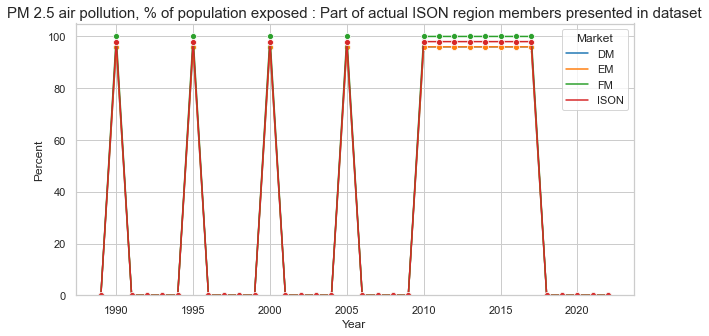

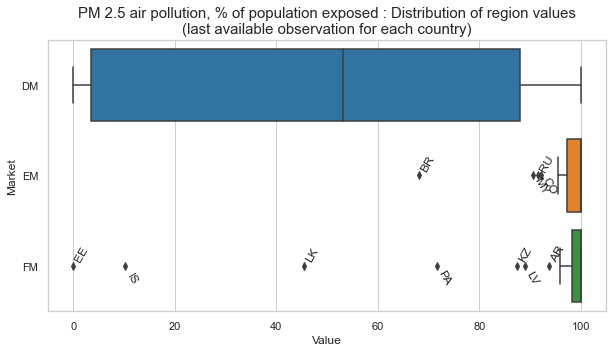

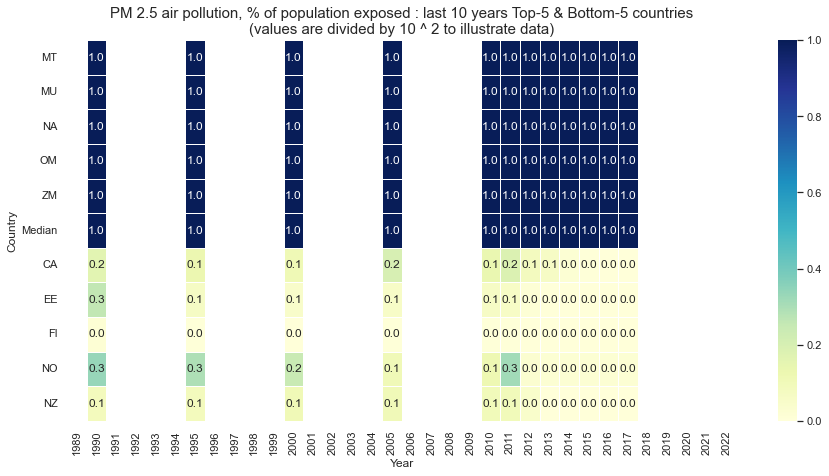

Natural resources depletion


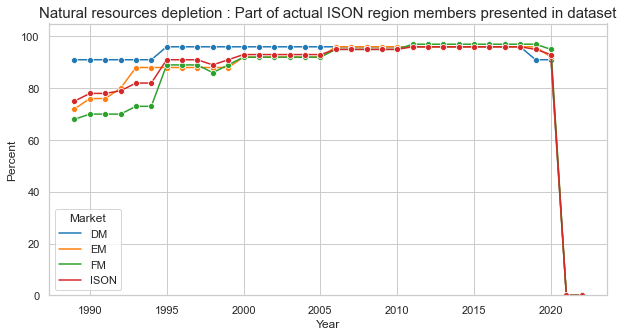

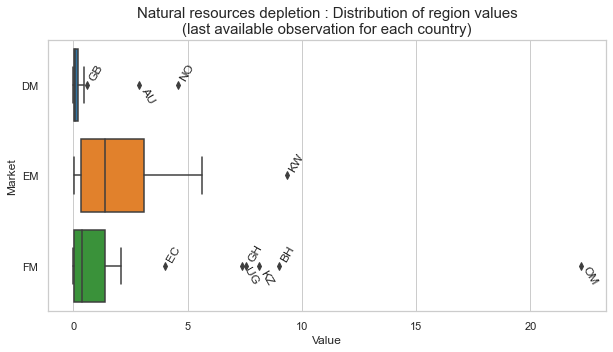

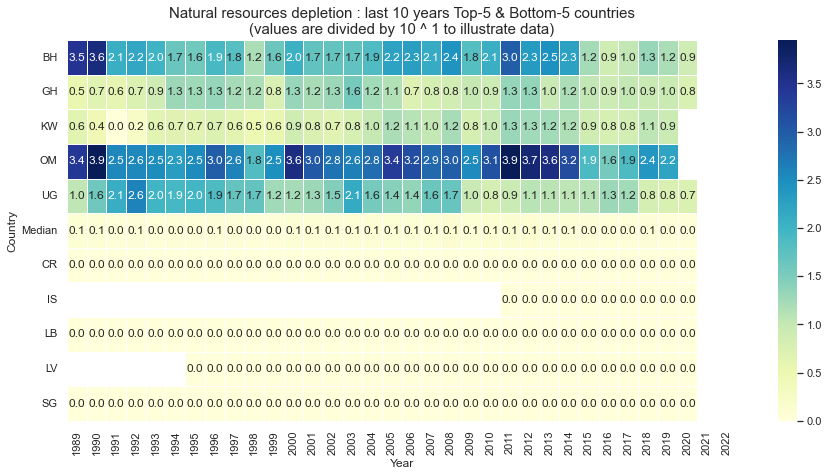

Waste per Capita


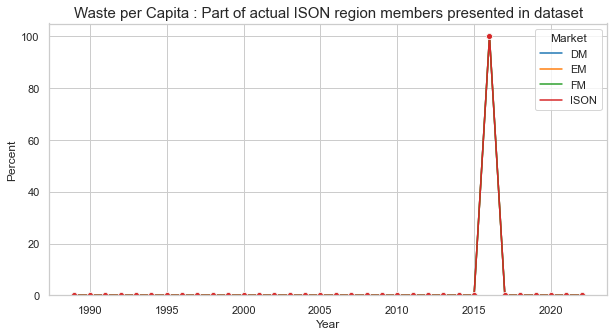

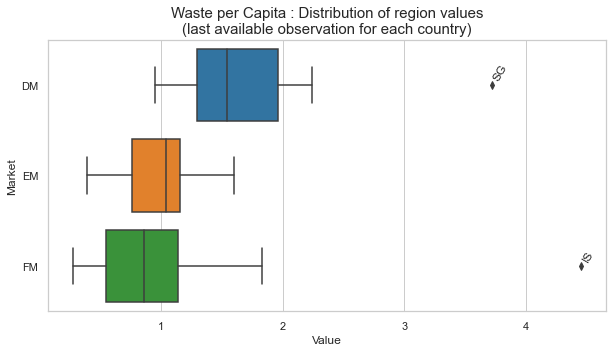

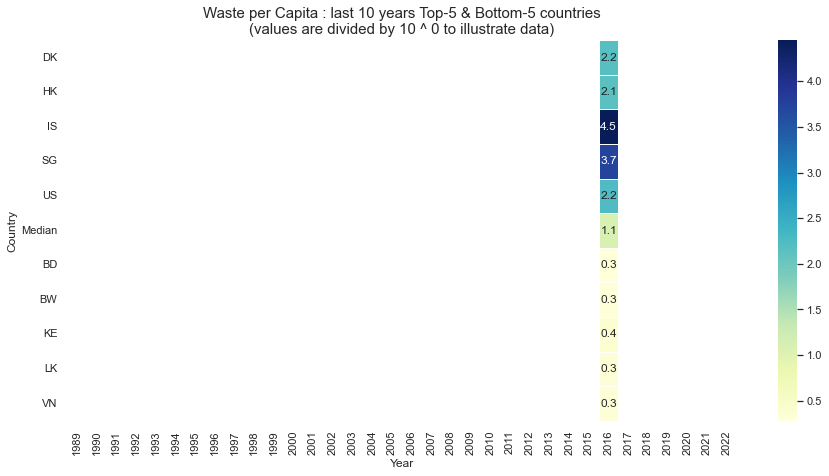

Water Stress


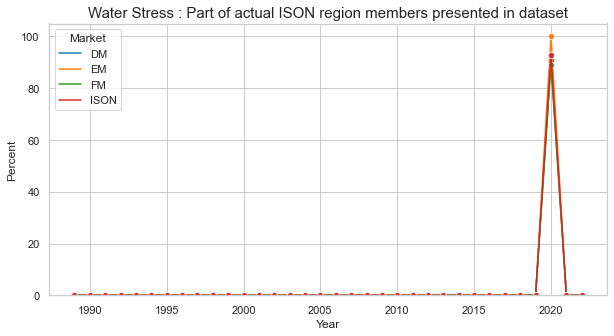

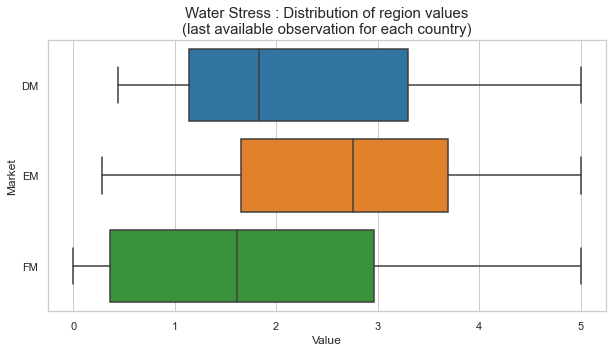

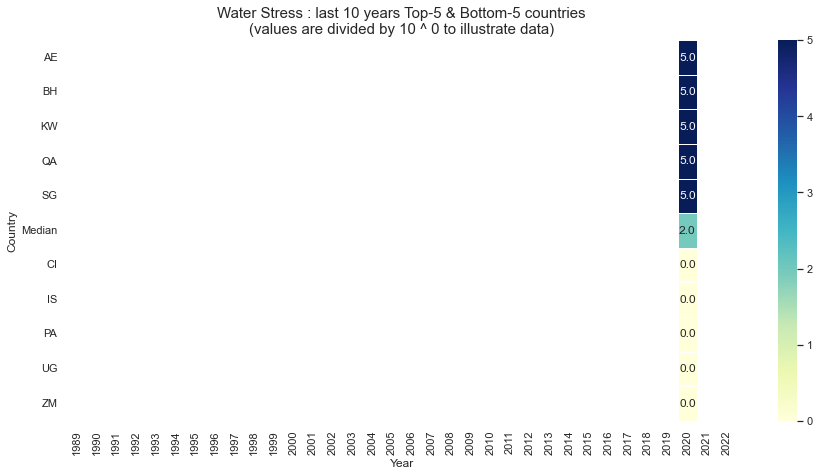

Biodiversity


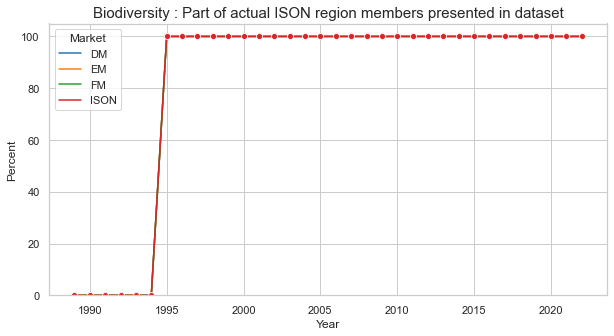

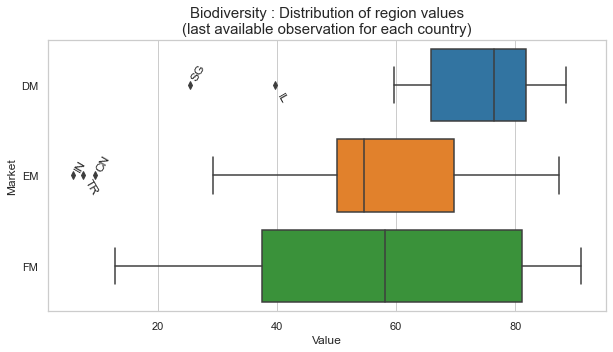

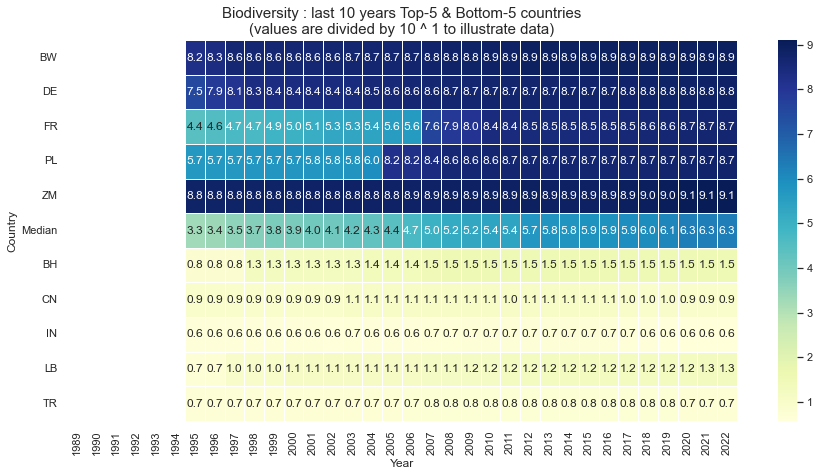

In [74]:
### ESG INDICATORS GENERAL STATISTICS

### Looping over attributes:
for iter_attr in df_all_var.columns:
    print(iter_attr)
    ### Extracting attribute data:
    ser_iter_attr = df_all_var[iter_attr].to_frame().join(ser_ison_status).set_index('Market', append = True).squeeze()
    ser_iter_attr.name = 'Value'
    ### Calculating of coverage:
    ser_iter_count = ser_iter_attr.groupby(['Date', 'Market']).count()
    ser_iter_ison = pd.concat({'ISON': ser_iter_count.groupby('Date').sum()}, names = ['Market']).swaplevel()
    ser_iter_count = pd.concat([ser_iter_count, ser_iter_ison], axis = 0).sort_index()
    ser_iter_part = ((ser_iter_count / ser_market_len).round(2) * 100).astype(int)
    ser_iter_part.name = 'Percentage'
    ### Coverage plotting:
    df_to_plot = ser_iter_part.reset_index()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ax_coverage = sns.lineplot(data = df_to_plot, x = 'Year', y = 'Percentage', hue = 'Market', marker = 'o')
    ax_coverage.set_title(iter_attr + ' : Part of actual ISON region members presented in dataset', fontsize = 15)
    ax_coverage.set(ylim = (0, 105), ylabel = 'Percent')
    plt.show()   
    ### Distribution plotting:
    df_to_plot = ser_iter_attr.groupby(['Country', 'Market']).last().dropna().reset_index()
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ax_box = sns.boxplot(data = df_to_plot, x = 'Value', y = 'Market', order = list_regions)
    ### Fliers annotation:
    for iter_num, iter_region in enumerate(list_regions):
        list_fliers = boxplot_stats(df_to_plot[df_to_plot['Market'] == iter_region].drop(['Country', 'Market'], axis = 1))[0]['fliers']
        int_angle = 60
        flo_shift = -0.05
        for iter_flier in sorted(list_fliers):
            str_iter_country = df_to_plot.loc[(df_to_plot['Market'] == iter_region) & (df_to_plot['Value'] == iter_flier), 'Country'].values[0]
            ax_box.text(s = str_iter_country, x = iter_flier, y = iter_num + flo_shift, rotation = int_angle)            
            if (int_angle == 60):
                flo_shift = 0.2
            else:
                flo_shift = -0.05
            int_angle = -int_angle
    ### Title adding:
    ax_box.set_title(iter_attr + ' : Distribution of region values' + '\n' + '(last available observation for each country)', fontsize = 15)
    plt.show()
    ### Largest / smallest values preparation:
    int_n_countries = 5
    int_n_years = 10
    ser_iter_mean = ser_iter_attr.loc[ser_iter_attr.index.levels[0][-int_n_years : ]].groupby('Country').mean().dropna().sort_values(ascending = False)
    ### Leaders data preparation:
    df_iter_largest = ser_iter_attr.loc[All, ser_iter_mean[: int_n_countries].index, All].droplevel('Market').reset_index()
    df_iter_largest['Year'] = df_iter_largest['Date'].dt.year
    df_iter_largest = df_iter_largest.drop('Date', axis = 1).set_index(['Country', 'Year']).unstack('Year').sort_index()
    ### Outsiders data preparation:
    df_iter_smallest = ser_iter_attr.loc[All, ser_iter_mean[-int_n_countries :].index, All].droplevel('Market').reset_index()
    df_iter_smallest['Year'] = df_iter_smallest['Date'].dt.year
    df_iter_smallest = df_iter_smallest.drop('Date', axis = 1).set_index(['Country', 'Year']).unstack('Year').sort_index()
    ### Median timeseries:
    ser_iter_median = ser_iter_attr.groupby('Date').median()
    df_iter_median = pd.concat({'Median': ser_iter_median}, names = ['Country']).swaplevel().reset_index()
    df_iter_median['Year'] = df_iter_median['Date'].dt.year
    df_iter_median = df_iter_median.drop('Date', axis = 1).set_index(['Country', 'Year']).unstack('Year').sort_index()
    ### Data aggregation:
    df_to_plot = pd.concat([df_iter_largest, df_iter_median, df_iter_smallest], axis = 0)
    df_to_plot.columns = df_to_plot.columns.droplevel(0)
    int_digits = int(np.log10(df_to_plot.max().max()))
    df_to_plot = (df_to_plot / (10 ** int_digits))    
    ### Heatmap plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False,
                             annot = True, fmt = '0.1f')
    ax_heatmap.set_title(iter_attr + ' : last ' + str(int_n_years) + ' years Top-' + str(int_n_countries) + ' & Bottom-' + str(int_n_countries) + ' countries' + 
                         '\n' + '(values are divided by 10 ^ ' + str(int_digits) + ' to illustrate data)' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()      
#    break

In [ ]:
### TEMP



In [ ]:
### TEMP

